In [ ]:
pip install shap

In [1]:
import os
import joblib
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from src.model import get_model
import matplotlib.pyplot as plt
from utils.evaluate import evaluate_model,shap_explainer
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# import mlflow
# import mlflow.sklearn
# from sklearn.metrics import roc_auc_score, accuracy_score
# from mlflow.models.signature import infer_signature

In [2]:
# Create a folder named "outputs" and "pickle"
os.makedirs("outputs", exist_ok=True)
os.makedirs("pickle", exist_ok=True)

In [3]:
# Load data
data = pd.read_csv(r'C:\Users\Preema S\Desktop\AI-Intrusion-Detection\dataset\intrusion_detection_dataset.csv')
print(data.head())
# Optional: Sample numeric columns for visualization
numeric_cols = data.select_dtypes(include='number').columns

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   1.242872  -2.846242   1.631471   0.616130   1.024352   3.776219   
1   4.910051  -0.803401  -1.785864  -1.706847  -0.070520  -2.213141   
2   0.995002   4.472860   0.396552  -0.774943  -0.539313   1.983609   
3  -6.064907  -0.861145  -0.663774   0.639216   1.399097   0.464887   
4  -3.663457  -2.540896  -0.362081  -1.018162   1.939464  -1.736997   

   feature_7  feature_8  feature_9  feature_10  ...  feature_12  feature_13  \
0   2.207521  -4.202171   0.464731   -3.293098  ...   -2.365571    1.826469   
1  -0.034315   9.526943   3.740554   -6.521879  ...    0.685556   -5.243079   
2   1.571684  -1.178277   1.175303    1.666403  ...    2.167063   -1.271422   
3  -7.810023  -0.833776   1.906510    1.299077  ...    0.287488    0.340744   
4  -2.255150   6.621085  -3.086259   -5.767685  ...    3.516086    2.774681   

   feature_14  feature_15  feature_16  feature_17  feature_18  feature_19  \
0    0.942230   -0.01

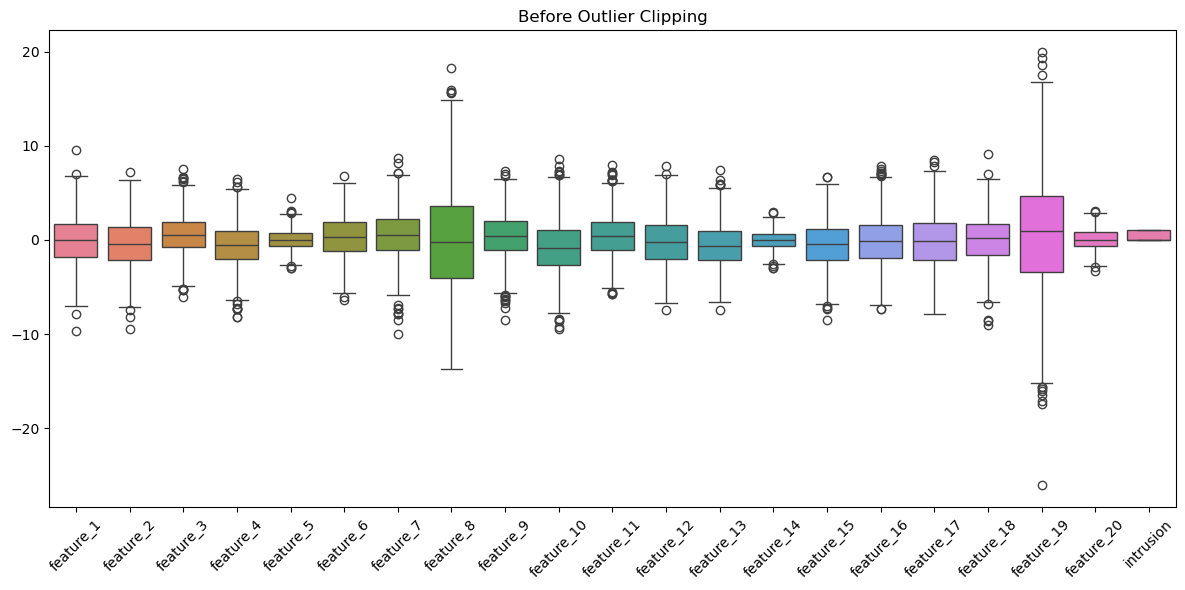

In [4]:
# Boxplot before clipping
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numeric_cols])
plt.title("Before Outlier Clipping")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/Before_Outlier_Clipping.jpg')
plt.show()

In [5]:
# Perform clipping (as before)
for col in data.select_dtypes(include='number').columns:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = data[col].clip(lower, upper)

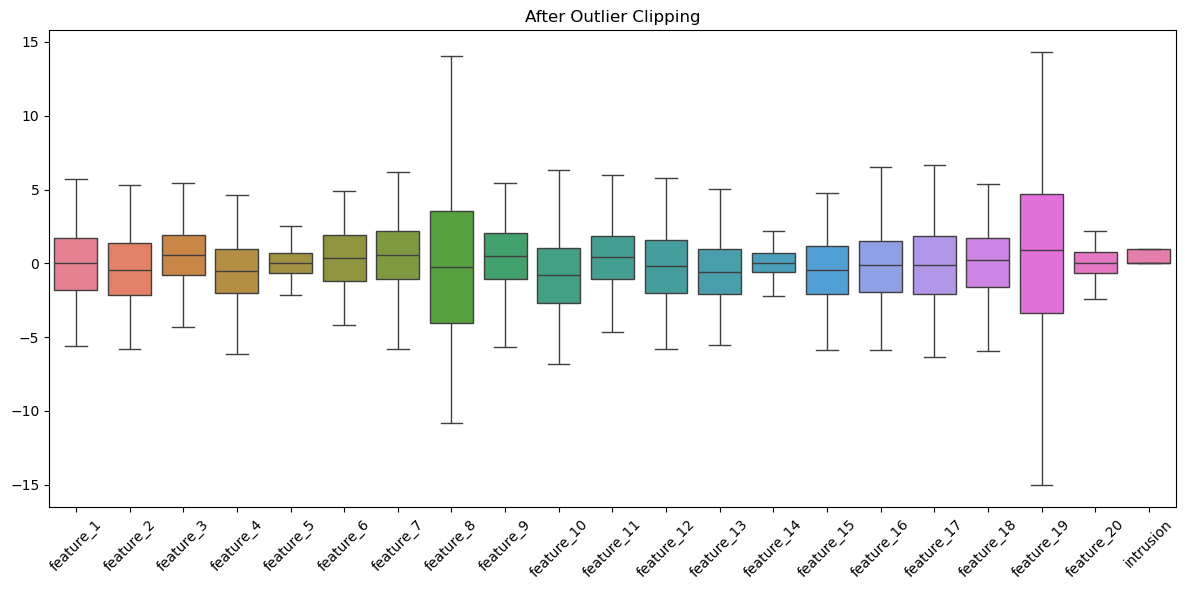

In [6]:
# Boxplot after clipping
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numeric_cols])
plt.title("After Outlier Clipping")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/After_Outlier_Clipping.jpg')
plt.show()


In [7]:
# Assume last column is label
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,1.242872,-2.846242,1.631471,0.616130,1.024352,3.776219,2.207521,-4.202171,0.464731,-3.293098,1.848779,-2.365571,1.826469,0.942230,-0.011058,-3.312649,-3.227888,0.703651,4.432210,-0.429676
1,4.910051,-0.803401,-1.785864,-1.706847,-0.070520,-2.213141,-0.034315,9.526943,3.740554,-6.521879,1.763536,0.685556,-5.243079,-0.352180,1.901790,-0.846546,0.195492,5.229226,8.772250,-1.564854
2,0.995002,4.472860,0.396552,-0.774943,-0.539313,1.983609,1.571684,-1.178277,1.175303,1.666403,0.025384,2.167063,-1.271422,-0.150584,-2.553335,2.556613,0.109192,-2.650392,-0.891219,0.936507
3,-5.622982,-0.861145,-0.663774,0.639216,1.399097,0.464887,-5.800266,-0.833776,1.906510,1.299077,0.664741,0.287488,0.340744,0.145996,0.116981,3.652516,0.400101,-1.136077,-4.633471,0.620830
4,-3.663457,-2.540896,-0.362081,-1.018162,1.939464,-1.736997,-2.255150,6.621085,-3.086259,-5.767685,-1.680432,3.516086,2.774681,0.623417,0.288686,3.795548,-0.541960,-2.213839,-8.462932,0.789908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.409122,1.001912,-1.288229,-0.403827,0.492523,-1.441248,-1.885862,-1.762801,-4.082646,-0.875871,-2.233711,-5.814833,-2.773690,0.499415,-0.202057,-4.350458,2.721992,2.376736,12.480685,0.327819
998,-0.044242,-0.026588,-0.598217,1.788028,1.255226,-0.328711,0.300140,4.781113,-0.427760,-6.805962,-1.790197,2.045385,3.388288,-0.048496,1.344746,-0.751725,5.686048,-1.448635,-4.874631,1.968654
999,-0.777866,-1.808516,2.976423,0.133447,-0.301219,1.326948,2.705706,-5.731992,1.977277,1.395705,0.675752,-2.366339,-2.154286,-0.723505,2.102490,-2.552263,-1.591984,1.310902,0.150968,-0.338928
1000,-0.849074,-1.705949,1.044910,0.783089,-0.040575,-0.341252,0.829347,-0.483243,2.115115,-4.720911,-1.098400,-0.154079,3.855858,-0.154600,1.800644,0.294403,4.576165,-1.128256,-9.897286,-0.007471


In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Fit on training data, transform both train and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'pickle/Standard_Scaler.pkl')

['pickle/Standard_Scaler.pkl']

In [12]:
# Get model
def get_model(use_grid_search=False):
    base_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss'
    )

    if use_grid_search:
        param_grid = {
            'max_depth': [4, 6],
            'learning_rate': [0.1, 0.2],
            'n_estimators': [100, 200]
        }

        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=3,
            verbose=1,
            n_jobs=-1
        )
        return grid_search

    return base_model


model = get_model()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
best_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


# Create SHAP explainer
def shap_explainer(model,X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot (feature impact)
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)

    # Save plot as image (optional)
    plt.savefig('outputs/shap_summary_plot.png',bbox_inches='tight')
    plt.show()

Confusion Matrix:
[[98 14]
 [ 8 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       112
           1       0.85      0.91      0.88        88

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



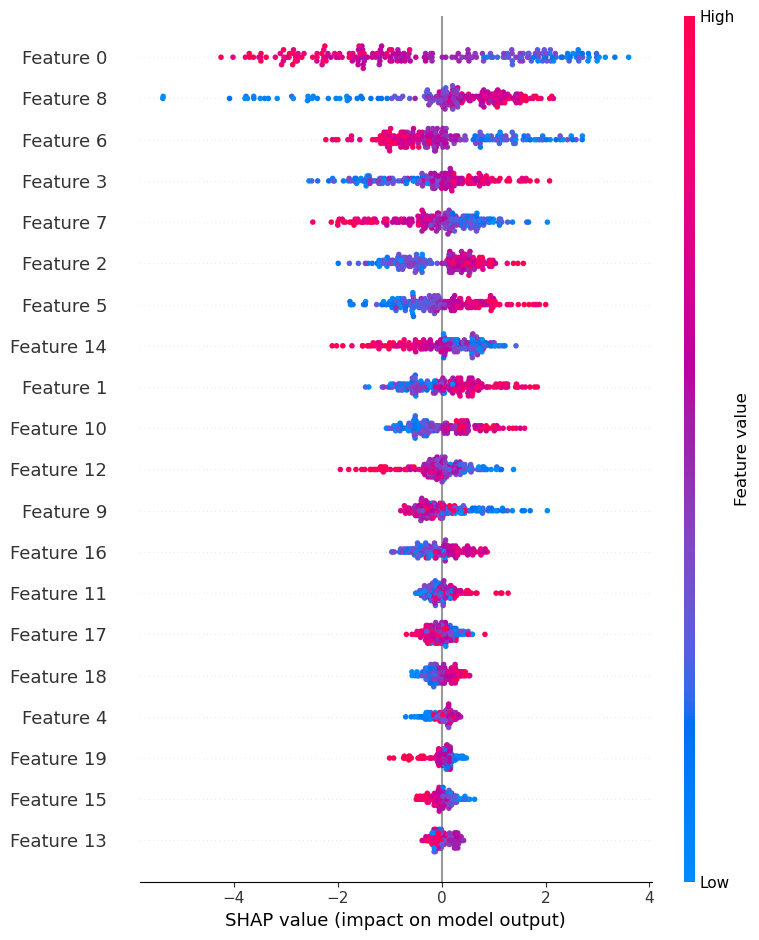

In [16]:
evaluate_model(model, X_test, y_test)
shap_explainer(model,X_test)

<Figure size 1000x600 with 0 Axes>

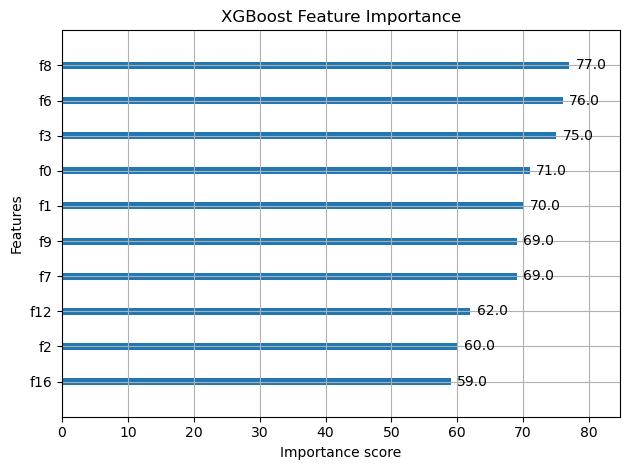

In [17]:
# Plot top 10 features
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig('outputs/XGBoost_Feature_Importance.jpg')
plt.show()

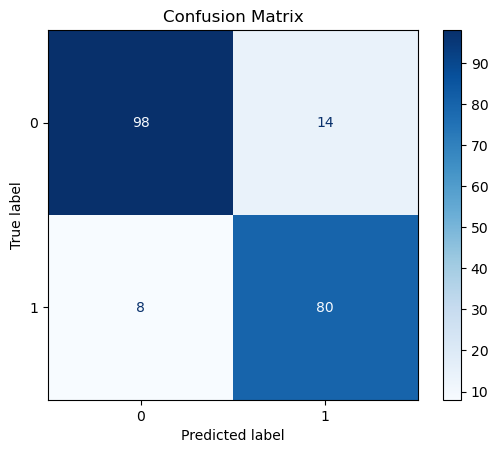

In [18]:
# Confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("outputs/Confusion_Matrix.jpg")
plt.show()

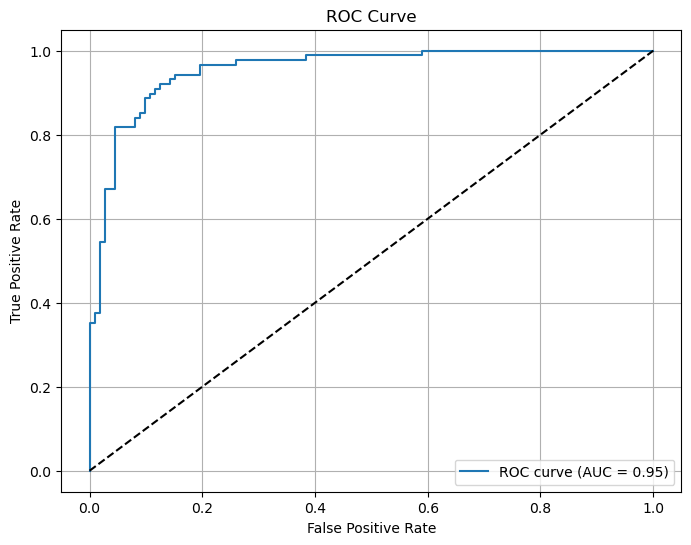

In [19]:
# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('outputs/ROC_Curve.jpg')
plt.show()

In [20]:
# pickle file
joblib.dump(model, 'pickle/xgboost_intrusion_model.pkl')

['pickle/xgboost_intrusion_model.pkl']